# Journey to Springfield

# 0. Initialization of all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, datasets

Initialization of random parameters to make learning process repeatable

In [12]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# 1. Initialization of the data set

In [13]:
DATA_DIR  = 'journey-springfield/'
TRAIN_DIR = DATA_DIR + 'train/simpsons_dataset/'
TEST_DIR  = DATA_DIR + 'testset/testset/'

-> [Official `pathlib` documentation](https://docs.python.org/3/library/pathlib.html)

In [14]:
train_files = sorted(list(Path(TRAIN_DIR).rglob('*.jpg')))
test_files  = sorted(list(Path(TEST_DIR).rglob('*.jpg')))

In [15]:
train_labels = pd.Series([path.parent.name for path in train_files]).value_counts().sort_values().to_frame('count')

In [16]:
train_labels

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


That's clearly seen that there're only 3 images of `Lionel Hutz` in the set, while it's more than two thousand in case for `Homer`. Data set extremly unbalanced and it will be necessary to use augmentations

# 2. Augmentations of images and data loader

In [8]:
SCALE_SIZE = 224

In [33]:
augmentations = transforms.RandomChoice([ #chose whether to flip, or rotate, or resize the picture
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(size=250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1)
])

train_transform = transforms.Compose([
    augmentations, 
    transforms.Resize(size = (SCALE_SIZE, SCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size = (SCALE_SIZE, SCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [77]:
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)

In [78]:
class TestDataset(Dataset): #pure photos loader, difference with train is lack of the class headers in test dataset
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        img = Image.open(self.files[index]).convert('RGB')
        return test_transform(img)
    
    def __len__(self):
        return len(self.files)

In [34]:
test_dataset = TestDataset(test_files)
test_loader  = DataLoader(test_dataset, shuffle=False)

Now i will rebalance weights of different types

In [82]:
class_counters = Counter(train_dataset.targets)
class_weights  = {i : 1/c for i, c in class_counters.items()}
sample_weights = [0] * len(train_dataset)

for i, (data, label) in enumerate(tqdm(train_dataset)):
    sample_weights[i] = class_weights[label]

N = max(class_counters.values()) * len(class_counters)

  0%|          | 0/20933 [00:00<?, ?it/s]

Data loaders

In [83]:
BATCH_SIZE = 256 
N_WORKERS  = 2

In [84]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_WORKERS)

Images output

In [85]:
#imshow for normalized tensors
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

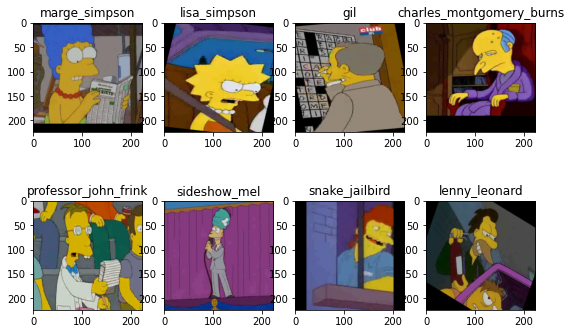

In [88]:
plot, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))

data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

# 3. Model and its implementation 

In [44]:
in_features = 2400
in_between_features = 2000
out_features = 42

For the model i've chosen upgraded version of AlexNet (with more convolution layers)

In [42]:
class SimpsonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.max = nn.Softmax()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 96, kernel_size=3)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear1 = nn.Linear(in_features, in_between_features)
        self.linear2 = nn.Linear(in_between_features, out_features)

    def forward(self, X):
        X = self.activation(self.pool1((self.conv1(X))))
        X = self.activation(self.pool2((self.conv2(X))))
        X = self.activation(self.pool3((self.conv3(X))))
        X = self.activation(self.pool4((self.conv4(X))))
        X = self.activation(self.pool5((self.conv5(X))))
        
        X = self.flatten(X)
        X = self.linear1(X)
        X = self.activation(X)
        X = self.linear2(X)

        return X

# 4. Fitting process 

In [21]:
!nvidia-smi

Fri Nov 25 10:58:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P3    17W /  N/A |    479MiB /  4096MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.cpu()

In [37]:
torch.cuda.is_available()

True

In [24]:
def fit(model, train_loader, criterion, optimizer, scheduler):
    current_loss = 0
    current_corr = 0
    proccesed_data = 0
    
    for x_epoch, y_epoch in train_loader:
        x_epoch = x_epoch.to(device)
        y_epoch = y_epoch.to(device)

        optimizer.zero_grad()

        prediction = model(x_epoch)
        try:
            loss = criterion(prediction, y_epoch)
        except:
            print(y_epoch)
        loss.backward()
        optimizer.step()

        current_loss += loss.item() * x_epoch.size(0)
        current_corr += torch.sum(torch.nn.functional.softmax(prediction, dim = -1).argmax(-1) == y_epoch.data)
        proccesed_data += x_epoch.size(0)
        
    scheduler.step()

    train_loss = current_loss / proccesed_data
    train_acc  = current_corr.cpu().numpy() / proccesed_data

    return train_loss, train_acc

In [25]:
def train(model, criterion, optimizer, scheduler, epochs, batch_size):
    history = []
    log = '\nEpoch {epoch:03d}, train_loss:{loss:04f}, train_acc:{acc:04f}'

    with tqdm(desc='Epoch', total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss, train_acc = fit(model, train_loader,  criterion, optimizer, scheduler)
            history.append([train_loss, train_acc])

            pbar.update(1)
            tqdm.write(log.format(epoch=epoch+1, loss=train_loss, acc=train_acc))

    return history

Right now i wont give much credit to `learning rate` and `gamma` values. Will change them later

In [26]:
model_ = SimpsonsNet().to(device)
crit  = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_.parameters(), amsgrad=True, lr=1e-3)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

In [32]:
history = train(model=model_, criterion=crit, optimizer=optim, scheduler=sched, epochs=20, batch_size=BATCH_SIZE)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001, train_loss:1.434953, train_acc:0.617956

Epoch 002, train_loss:0.406170, train_acc:0.887302

Epoch 003, train_loss:0.247553, train_acc:0.929048

Epoch 004, train_loss:0.173049, train_acc:0.949148

Epoch 005, train_loss:0.134328, train_acc:0.960968

Epoch 006, train_loss:0.103157, train_acc:0.970498

Epoch 007, train_loss:0.083703, train_acc:0.975724

Epoch 008, train_loss:0.045389, train_acc:0.986675

Epoch 009, train_loss:0.034882, train_acc:0.989929

Epoch 010, train_loss:0.029377, train_acc:0.991572

Epoch 011, train_loss:0.026591, train_acc:0.992389

Epoch 012, train_loss:0.022761, train_acc:0.993618

Epoch 013, train_loss:0.021648, train_acc:0.994148

Epoch 014, train_loss:0.019127, train_acc:0.994615

Epoch 015, train_loss:0.016898, train_acc:0.995283

Epoch 016, train_loss:0.016742, train_acc:0.995484

Epoch 017, train_loss:0.016819, train_acc:0.995378

Epoch 018, train_loss:0.015612, train_acc:0.995601

Epoch 019, train_loss:0.017365, train_acc:0.995283

Epoch 020, 

In [75]:
#the reason this part exist is that i only ones taught my neural network while been struggling with jupyter many times
#history = [[1.434953, 0.406170, 0.247553, 0.173049, 0.134328, 0.103157, 0.083703, 0.045389, 0.034882, 0.029377, 0.026591, 0.022761, 0.021648, 0.019127, 0.016898, 0.016742, 0.016819, 0.015612, 0.015612, 0.014901],
#            [0.617956, 0.887302, 0.929048, 0.949148, 0.960968, 0.970498, 0.975724, 0.986675, 0.989929, 0.991572, 0.992389, 0.993618, 0.994148, 0.994615, 0.995283, 0.995484, 0.995378, 0.995601, 0.995283, 0.995982]]

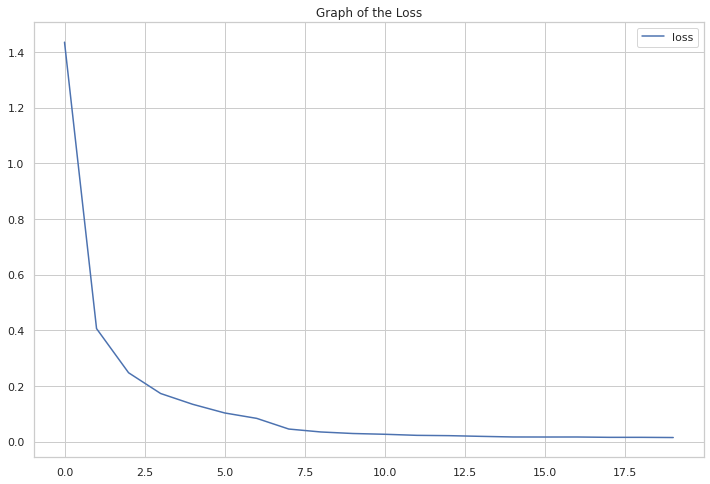

In [28]:
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')

plt.title('Graph of the Loss')
plt.plot(history[0], label = 'loss')
plt.legend()
plt.show()

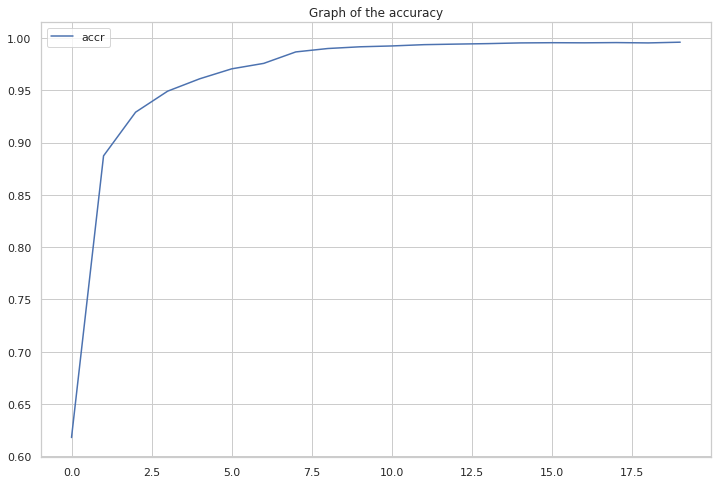

In [29]:
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')

plt.title('Graph of the accuracy')
plt.plot(history[1], label = 'accr')
plt.legend()
plt.show()

How to read weights from the file https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [48]:
#torch.save(model_.state_dict(), 'SimpsonsNetWeights.pth') #the reason this part exist is that i only ones taught my neural network while been struggling with jupyter many times
#model_ = SimpsonsNet().to(device)
#model_.load_state_dict(torch.load('SimpsonsNetWeights.pth'))

<All keys matched successfully>

# 5. Test data prediction

In [49]:
def predict(model, set):
    results = []
    with torch.no_grad():
        for values in set:
            values = values.to(device)
            model.eval()

            prediction = model(values).cpu()
            results.append(prediction)
    return nn.functional.softmax(torch.cat(results), dim = -1).numpy()

In [64]:
probs = predict(model_, test_loader).argmax(-1)

In [65]:
probs

array([29,  4, 28,  7,  2, 16, 11,  7, 20, 16, 18, 22, 16, 28, 27,  9,  0,
       11, 16, 20, 22, 29,  9, 24, 15,  2, 17, 17, 28, 11,  2,  7,  2, 28,
       22,  0, 15, 37, 20,  6,  7, 16,  0, 25, 18,  0, 29,  9,  7, 29, 24,
        6,  2, 24,  4, 11, 11,  6, 28,  7,  7,  6, 22,  2, 18, 18,  9, 16,
       24, 37, 28, 28,  9,  6, 11,  4, 16, 28, 17,  9,  7, 24, 28, 17, 37,
       28,  7, 29,  0, 17, 15, 17, 20, 17, 24, 20, 27, 29, 22,  4,  7, 25,
        7, 16, 22, 20,  2,  6, 22,  2, 22,  2, 24, 22, 11, 15, 15,  4, 32,
       11, 25, 27, 18, 27, 32, 15, 18, 20, 37,  7,  2, 24,  6, 24, 16, 27,
       15, 20, 25,  2, 24,  6,  6,  4, 16, 20,  7, 27, 37, 20, 11, 17, 16,
       15,  6, 18, 29,  7, 29, 24, 28, 29, 22,  9, 15,  6, 18, 22,  2, 29,
       24,  4,  2, 15, 18, 25, 17,  0, 20,  0,  7, 15, 15, 17, 18, 18, 16,
        6, 37,  7, 11, 16,  2, 29,  4,  6, 24, 24,  7,  4,  0, 15, 29,  0,
       22,  7, 18, 28, 27, 22, 22, 16, 27,  6,  9,  2,  4, 11, 32, 18,  9,
       27, 17, 29, 17, 25

# 6. Output to kaggle

In [67]:
probs_classes = [train_dataset.classes[i] for i in probs]
probs_classes

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'c

In [68]:
probs_labels = [path.name for path in test_dataset.files]

In [74]:
pd.DataFrame(columns=['Id', 'Expected'], data = np.array([probs_labels, probs_classes]).T, index=None).to_csv('submission.csv', index=None)